# Tutorial on calculating $\delta$ vs. systematics

### V 0.1 Dec 21, 2017
Import required modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import healpy as hp
import fitsio as ft
import numpy as np
import sys
sys.path.insert(0,'/Users/mthecosmologist/Dropbox/github/DESILSS')
from syslss import ngalsys

In [2]:
%ls /Volumes/Mehdi_Passport/NERSC_archive/other_files/dr3.1/

ELG-RANDOM.txt_dr3.fits     depth_mask.fits
ELGsig0_deacm3.fits         dr3-3p1sec0.fits
LRG-RANDOM.txt_dr3.fits     healSFD_r_256_fullsky.fits
LRGsig0_deacm3.fits         heal_rbs_128v2.fits
RBSsig0_deacm3.fits         heal_rbs_256.fits


Read in galaxy and random catalogs, along with the desi target depth mask (4096), the healpix maps of R-band bright stars (256) and EBV (256). 

In [3]:
mask = hp.read_map('/Volumes/Mehdi_Passport/NERSC_archive/other_files/dr3.1/depth_mask.fits')
random = ft.read('/Volumes/Mehdi_Passport/NERSC_archive/other_files/dr3.1/ELG-RANDOM.txt_dr3.fits', upper=True)
galaxy = ft.read('/Volumes/Mehdi_Passport/NERSC_archive/other_files/dr3.1/ELGsig0_deacm3.fits', upper=True)
irs    = ft.read('/Volumes/Mehdi_Passport/NERSC_archive/other_files/dr3.1/heal_rbs_256.fits')
ebvr   = ft.read('/Volumes/Mehdi_Passport/work/quicksurvey/ELG/inputs/healSFD_r_256_fullsky.fits')

NSIDE = 4096
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


Look at the Mollweide projection of the R-band bright stars

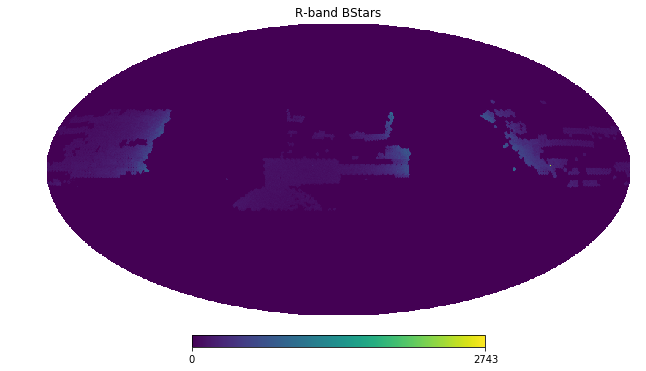

In [4]:
hp.mollview(irs, title='R-band BStars')

Upgrade the EBV and RBS maps to 4096

In [5]:
ebv = hp.ud_grade(ebvr/2.75, nside_out=4096,order_in='NEST', order_out='RING')
rbs = hp.ud_grade(irs, nside_out=4096)

Two classes which prepares our galaxy/random catalogs and systematics (EBV/RBS) for our ngalsys 

In [6]:
class cat(object):
    def __init__(self, catname):
        df = catname #ft.read(catname, lower=True)
        self.RA = df['RA']
        self.DEC = df['DEC']
        self.Weight = np.ones(df['RA'].size)
class systematic(object):
    def __init__(self, sysname, mask):
        df = sysname #ft.read(sysname, lower=True)
        self.HPIX = np.argwhere(~np.logical_not(mask)).flatten()
        self.SIGNAL = df[~np.logical_not(mask)]

In [7]:
galm = cat(galaxy)
ranm = cat(random)
ebv4096 = systematic(ebv, mask)
rbs4096 = systematic(rbs, mask)

## $\delta$ vs. EBV 

Before any calculation, let's see the histogram of ebv.signal

Text(0.5,0,'EBV')

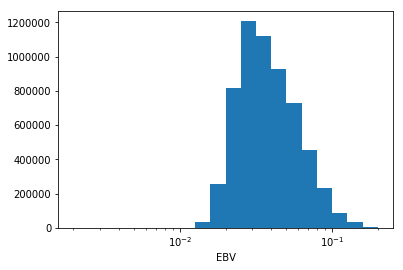

In [8]:
_=plt.hist(ebv4096.SIGNAL, bins=np.logspace(np.log10(0.002), np.log10(0.2), 21))
plt.xscale('log')
plt.xlabel('EBV')

In [9]:
dr3ebv = ngalsys(galm, 4096)
dr3ebv.prepare_inputs(ebv4096, random=ranm)
dr3ebv.digitize_ngalsys(np.logspace(np.log10(0.002), np.log10(0.2), 21))
dr3ebv.processjack()

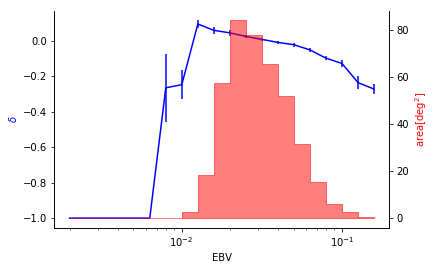

In [10]:
dr3ebv.quickplot(xlab='EBV')

## $\delta$ vs. R-band Bright Stars

Let's look at the histogram of RBS

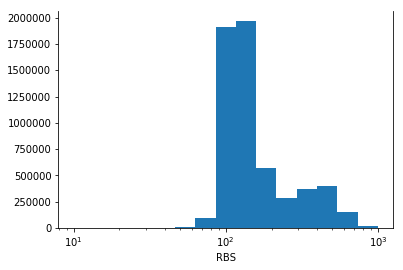

In [11]:
_=plt.hist(rbs4096.SIGNAL, bins=np.logspace(1, 3, 16))
plt.xlabel('RBS')
plt.xscale('log')

In [12]:
dr3rbs = ngalsys(galm, 4096)
dr3rbs.prepare_inputs(rbs4096, random=ranm)

In [13]:
dr3rbs.digitize_ngalsys(np.logspace(1, 3, 16))
dr3rbs.processjack()

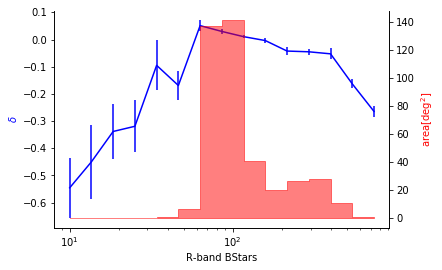

In [14]:
dr3rbs.quickplot('R-band BStars')

You can access to the systematic pixels and their indices as well

In [21]:
dr3rbs.sysmap.size, dr3rbs.ihpix.size, 12*4096**2

(7943207, 7943207, 201326592)